In [2]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [3]:
data, dataName = loadData.loadData("mt_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 500
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName



 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2156
Visual test duration range: 0.1072 to 1.0763


In [4]:
# read back the saved file to verify
import os
import json
import loadResults
try:
    res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
    res_with_new_lines = json.dumps(res, indent=4)
    print("Loaded saved fit results:\n")
    print(res_with_new_lines)
    #print(f"Loaded saved fit results: {res}")
    mc_fitter.modelFit= res['fittedParams']
    mc_fitter.logLikelihood= res['logLikelihood']
    mc_fitter.aic= res['AIC']
    mc_fitter.bic= res['BIC']
    mc_fitter.nDataPoints= res['n_conditions']
except:
    print("No saved fit results found, proceeding to fit the model.")
    user_input = input("Do you want to proceed with model fitting? (yes/no): ").strip().lower()
    if user_input != 'yes':
        print("Model fitting skipped.")
        
    timeStart = time.time()
    print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    print(f"\nFitted parameters for {dataName}: {fittedParams}")
    print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
    mc_fitter.modelFit= fittedParams
    mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)    
    
    #save the fit results
    import fitSaver
    fitSaver.saveFitResultsSingle(mc_fitter, mc_fitter.modelFit, dataName)

Looking for saved fit: mt_all with model lognorm_LapseFree_sharedPrior
Loaded saved fit results:

{
    "participantID": "mt",
    "modelType": "lognorm_LapseFree_sharedPrior",
    "fittedParams": [
        0.032721803495229546,
        0.15576154849977908,
        0.3718890945007365,
        0.7982787610074273,
        0.46007481075666873,
        0.14598556138063035,
        0.21001085452070584,
        0.5957054038783781,
        2.1428683373655852
    ],
    "AIC": 2209.9903735016615,
    "BIC": 2244.9151703792677,
    "logLikelihood": -1095.9951867508307,
    "n_conditions": 358
}


## Simulate data using fitted parameters

In [15]:
#proceed to simulate and save to {filename}
import fitSaver
import os
def loadSimulatedData(mc_fitter, dataName,participantID, modelType=mc_fitter.modelName):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData

    except:
        user_input = input(f"No saved simulated data found at {filename}. Do you want to simulate and save the data? (yes/no): ").strip().lower()
        if user_input != 'yes':
            print("No simulation found and selected to go with new sim.")
        else:
            return None
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)



Loaded saved simulated data from simulated_data/mt/mt_lognorm_LapseFree_sharedPrior_simulated.csv


In [16]:
# so now we have loaded the simulated data, fitted parameters, loglikelihood, aic, bic

In [5]:
# Load psychometric fits for both data and simulated data
import importlib
import psychometricFitLoader as pfl_data
import psychometricFitLoader_simulated as pfl_sim

# Get participant ID
dataID = dataName.split("_")[0]

# Load real data psychometric fit
mc_fitter.dataFit = pfl_data.load_psychometric_fit(dataID)
print(f"✅ Loaded real data psychometric fit for {dataID}")
print(f"   AIC: {mc_fitter.dataFit['AIC']:.2f}, Params: {mc_fitter.dataFit['n_params']}")
# Load simulated data psychometric fit
mc_fitter.simDataFit = pfl_sim.load_psychometric_fit_simulated(dataID, 'lognorm_LapseFree_sharedPrior')
print(f"✅ Loaded simulated data psychometric fit for {dataID}")
#print(f"   AIC: {mc_fitter.simulatedFit['AIC']:.2f}, Params: {mc_fitter.simulatedFit['n_params']}")


✅ Loaded real data psychometric fit for mt
   AIC: 2232.57, Params: 42
✅ Loaded simulated data psychometric fit for mt


In [ ]:
print("? Checking simulated data quality...")
print(f"Simulated data shape: {mc_fitter.simulatedData.shape}")
print(f"Columns: {list(mc_fitter.simulatedData.columns)}")

# Check a sample of responses
sample_data = mc_fitter.simulatedData.head(10)
print(f"\nSample simulated data:")
for idx, row in sample_data.iterrows():
    print(f"testDur={row['testDurS']:.3f}s, chose_test={row['chose_test']}, conflict={row['conflictDur']:.3f}, noise={row['audNoise']:.1f}")

# Check if there's variation in responses  
print(f"\nResponse variation:")
print(f"chose_test: {mc_fitter.simulatedData['chose_test'].value_counts().to_dict()}")
print(f"Unique test durations: {len(mc_fitter.simulatedData['testDurS'].unique())}")

print("\n?🔄 Refitting simulated data with correct log-space model...")
mc_fitter.simDataFit = mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData, 1)
print(f"✅ Refitted simulated data. Parameters length: {len(mc_fitter.simDataFit.x)}")
print(f"First few params: {mc_fitter.simDataFit.x[:9]}")  # Show first 3 conditions (lambda, mu, sigma each)

Plotting psychometric curves for Monte Carlo model and data...


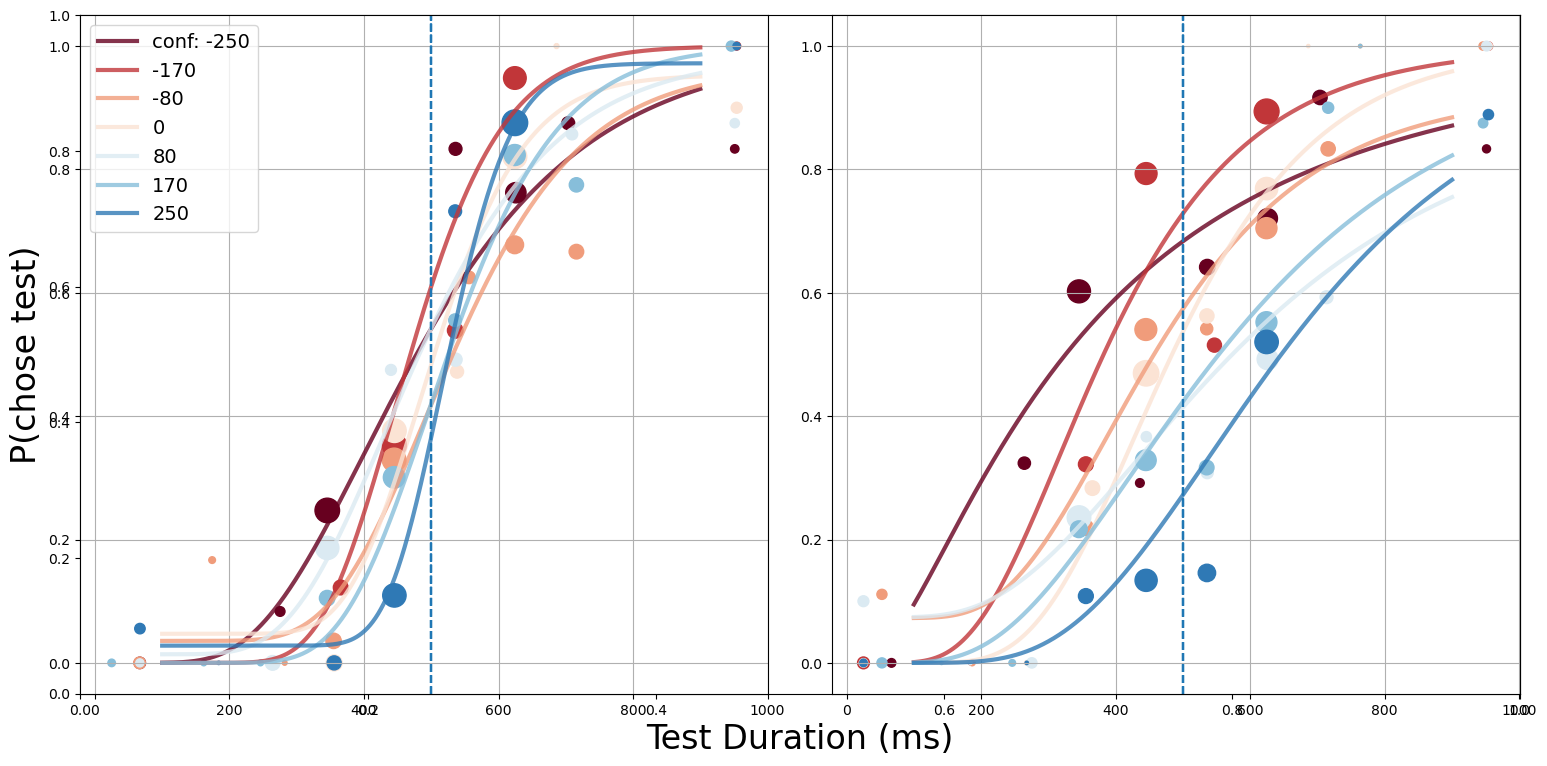

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue",binVar='delta_dur_percents'):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[binVar], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[binVar], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(binVar, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)

def plotPsychometrics_MC_Data(self):
    """Plot psychometric curves for Monte Carlo model and data"""
    print("Plotting psychometric curves for Monte Carlo model and data...")
    
    pltTitle = self.dataName + " "+ self.modelName+" Model Fit"
    plt.figure(figsize=(16, 8))
    plt.xlabel("Test Duration (ms)", fontsize=24)
    plt.ylabel("P(chose test)",fontsize=24)

    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                plt.subplot(1, 2, j + 1)
                
                # Create x-axis values in seconds for test durations
                x_test_dur_s = np.linspace(0.1, 0.9, 1000)  # Test durations in seconds
                # Standard duration is constant for this condition
                x_standard_dur_s = np.full_like(x_test_dur_s, standardLevel)
                
                color = sns.color_palette("RdBu", as_cmap=True)(k / len(self.uniqueConflict))
                
                # USE REAL DATA FIT instead of broken simulated fit
                # Extract parameters for this condition from REAL data fit
                params_array = self.dataFit['parameters']
                paramsDataFit = self.getParams(params_array, conflictLevel, audioNoiseLevel)
                
                # Plot psychometric curve from REAL DATA fit (should be good)
                yDataSigmoid = self.psychometric_function(x_test_dur_s, x_standard_dur_s, paramsDataFit[0], paramsDataFit[1], paramsDataFit[2])

                # Convert to milliseconds for plotting
                xPlot = x_test_dur_s * 1000  # Convert seconds to ms
                if k==0:
                    plt.plot(xPlot, yDataSigmoid, color=color, linestyle='-', label=f"conf: {int(conflictLevel*1000)}", linewidth=3, alpha=0.8)
                else:
                    plt.plot(xPlot, yDataSigmoid, color=color, linestyle='-', linewidth=3, alpha=0.8,label=f"{int(conflictLevel*1000)}")
                plt.axvline(standardLevel * 1000, linestyle='--')  # Show standard duration line

                # Extract Monte Carlo parameters
                lambda_, sigma_av_a, sigma_av_v, p_c ,tmin,tmax= self.getParamsCausal(self.modelFit, audioNoiseLevel, conflictLevel)

                if j==0:
                    plt.legend(fontsize=14, title_fontsize=20)
                plt.grid()

                # Plot real data points
                groupedDataSub = self.groupByChooseTest(
                    self.data[(self.data[self.standardVar] == standardLevel) & (self.data[self.sensoryVar] == audioNoiseLevel) & (self.data[self.conflictVar] == conflictLevel)],
                    [self.intensityVar, self.sensoryVar, self.standardVar, self.conflictVar, self.visualStandardVar, self.visualTestVar, self.audioTestVar, "testDurMs"]
                )
                bin_and_plot(groupedDataSub, bin_method='cut', bins=10, plot=True, color=color,binVar='testDurMs')
                plt.tight_layout()
                
    plt.show()

plotPsychometrics_MC_Data(mc_fitter)

In [ ]:


# print(f"✅ Loaded real data psychometric fit for {dataID}")
# print(f"   AIC: {mc_fitter.dataFit['AIC']:.2f}, Params: {mc_fitter.dataFit['n_params']}")

# # Load simulated data psychometric fit
# try:
#     mc_fitter.simDataFit = pfl_sim.load_psychometric_fit_simulated(
#         dataID, 
#         'lognorm_LapseFree_sharedPrior'
#     )
#     print(f"✅ Loaded simulated psychometric fit for {dataID}")
#     print(f"   AIC: {mc_fitter.simDataFit['AIC']:.2f}, Params: {mc_fitter.simDataFit['n_params']}")
    
#     # Compare data vs simulated
#     comparison = pfl_sim.compare_data_vs_simulated(
#         dataID, 
#         'lognorm_LapseFree_sharedPrior',
#         data_fits_dir='psychometric_fits_data',
#         sim_fits_dir='psychometric_fits_simulated'
#     )
#     print(f"\n📊 Comparison:")
#     print(f"   Data AIC: {comparison['data_AIC']:.2f}")
#     print(f"   Simulated AIC: {comparison['simulated_AIC']:.2f}")
#     print(f"   Delta AIC: {comparison['delta_AIC']:.2f}")
    
# except FileNotFoundError as e:
#     print(f"⚠️  Simulated fit not found: {e}")
#     print(f"   Run: python runDataFitter_simulated.py")

# Plot the fits